# Check of solution

The routine for check of constraint and evaluation of the deviation will be performed below. The multisegment pseudospectral method itself is implemented pscontrol.py.

In [1]:
import cloudpickle
from ps_control import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

In [14]:
folder = 'data_traj'
i = -1
file_names = ['orchard', 'columns', 'random_spheres', 'forest', 'walls','example','simple']

In [15]:
with open('data_traj/ps_'+file_names[i]+'.pkl', mode='rb') as file:
   m = cloudpickle.load(file)

In [16]:
for j in m.nx:
    print(value(m.dynamics_const[j+1]))

-7.182680798543747e-08
-2.5458298950885193e-08
-4.8322954810942065e-06
5.517324147576122e-09
-4.268055083788165e-09
-6.63284406945408e-05
9.626394489328351e-07
3.910636800667237e-09
-7.518377772075927e-08
-1.7026855493837176e-08
0.0001526072469539841
-0.00016681682471109127
0.00020988276287270402


In [17]:
with open(folder+'/'+'ps_sol_'+file_names[i]+'.pkl', 'rb') as file:
    # Call load method to deserialze
    solution = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'data_traj/ps_sol_simple.pkl'

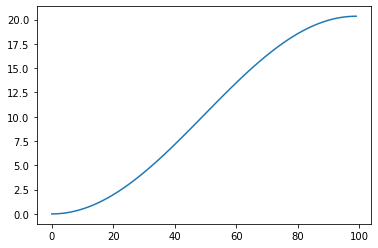

In [6]:
plt.plot(solution.time[:])


In [7]:
def getPolynomial(y,t,n):
    """Return polynomial of n-th order"""
    return np.polynomial.Polynomial.fit(t,y,n)

def getPolynomialWLagrange(y,t):
    """Return polynomial of n-th order"""
    return np.polynomial.Polynomial(lagrange(t,y).coef[::-1])
        
def getPolynomials(y,t,n_col):
    """Return array of polynomials for each segment"""
    p = []
    n_col_add = np.zeros(solution.n_col.shape[0]+1, dtype=int)
    for i, cols in enumerate(n_col):
        n_col_add[i+1] = n_col_add[i] + cols
        p.append(getPolynomial(y[n_col_add[i]:n_col_add[i+1]],t[n_col_add[i]:n_col_add[i+1]],cols))
    return p

def getPolynomialsWLagrange(y,t,n_col):
    """Return array of polynomials for each segment"""
    p = []
    n_col_add = np.zeros(solution.n_col.shape[0]+1, dtype=int)
    for i, cols in enumerate(n_col):
        n_col_add[i+1] = n_col_add[i] + cols
        p.append(getPolynomialWLagrange(y[n_col_add[i]:n_col_add[i+1]],t[n_col_add[i]:n_col_add[i+1]]))
    return p

def getNPolynomials(Y,t,n_col):
    """Returns array of N functions Y[N,t] for each segment """
    pY = []
    for y in Y:
        pY.append(getPolynomials(y,t, n_col))
    return pY

def getNPolynomialsWLagrange(Y,t,n_col):
    """Returns array of N functions Y[N,t] for each segment """
    pY = []
    for y in Y:
        pY.append(getPolynomialsWLagrange(y,t, n_col))
    return pY

def getPolyDerivative(p):
    """Return 1st derivative of polynomial"""
    return p.deriv(1)

pY = getNPolynomials(solution.state,solution.time, solution.n_col)
pY2 = getNPolynomialsWLagrange(solution.state,solution.time, solution.n_col)

/home/zboucek/anaconda3/envs/traj/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


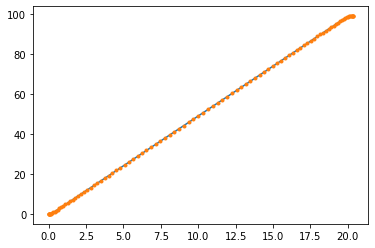

In [8]:
# eval polynomial
t = np.linspace(solution.time[0],solution.time[-1],int(solution.time.shape[0]*1e2))
i = 1
plt.plot(t,pY[i][0](t))
# plt.plot(t,pY2[i][0](t))
plt.plot(solution.time, solution.state[i,:],'.')

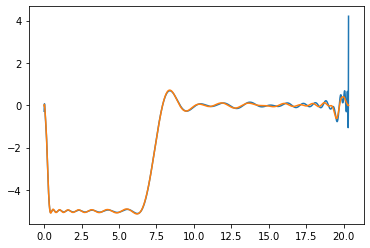

In [9]:
# calc and plot polynomial derivative 
i = 0
dpY = pY[0][0].deriv(1)
plt.plot(t,dpY(t))
plt.plot(t,pY[i+3][0](t))

In [10]:
import numpy as np

a = 0
b = np.pi
n = 11
h = (b - a) / (n - 1)
x = np.linspace(a, b, n)
f = np.sin(x)

I_simp = (h/3) * (f[0] + 2*sum(f[:n-2:2]) \
            + 4*sum(f[1:n-1:2]) + f[n-1])
err_simp = 2 - I_simp

print(I_simp)
print(err_simp)

2.0001095173150043
-0.00010951731500430384


In [11]:
def localDiscratizationError(t0,tf,dx, f_dyn,x,u,n=10):
    """ 
    Get approximate local discretization error by calculating 
    the intergral int_t0^tf abs(dx(t) - f(x(t),u(t),t)) dt  using composite Simpson's rule.
    Implemented according to https://pythonnumericalmethods.berkeley.edu/notebooks/chapter21.04-Simpsons-Rule.html
    """
    h = (tf - t0) / (n - 1)
    t = np.linspace(t0, tf, n)
    #eval abs(dx(tk) - f_dyn(x(tk),u(tk),tk)), where k = 0,...,n
    f = np.zeros(x(t0).shape[0],n)
    for tk in t:
        f.append(np.abs(dx(tk) - f_dyn(x(tk),u(tk))))
    I_simp = (h/3) * (f[0] + 2*sum(f[:n-2:2]) \
            + 4*sum(f[1:n-1:2]) + f[n-1])
    return I_simp
    

In [13]:
pX = pY[0:12][0]